In [1]:
# 05_sp500_cs_tree_robustness.ipynb
# Robustness of cross-sectional SP500 tree vs momentum across multiple test windows

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

import joblib
from pathlib import Path


import optuna
from sklearn.ensemble import HistGradientBoostingRegressor

plt.style.use("seaborn-v0_8-darkgrid")

def sharpe_ratio_np(returns, freq: int = 252) -> float:
    """Simple annualized Sharpe on a 1D array of daily returns."""
    r = np.asarray(returns, dtype=float)
    if r.size == 0 or np.isclose(r.std(), 0.0):
        return 0.0
    return np.sqrt(freq) * r.mean() / r.std()


C:\Users\gehra\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

from src.data_loading_cross import load_sp500_adj_close
from src.signals_cross import (
    make_cross_sectional_signals,
    build_cross_sectional_matrix,
    CROSS_FEATURES,
)

from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [3]:
# --- Global transaction cost setting ---
# round-trip cost as a fraction of notional per 21-day "trade"
# 0.0005 = 5 bps, 0.001 = 10 bps, etc.
COST_BPS = 0.001  # tweak this to whatever you want to assume


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6530 entries, 2000-01-03 to 2025-12-17
Columns: 453 entries, NVDA to NWS
dtypes: float64(453)
memory usage: 22.6 MB
Price panel shape: (6530, 453)
Date range: 2000-01-03 00:00:00 -> 2025-12-17 00:00:00
Number of tickers: 453


c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1 = prices.pct_change(1)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_5 = prices.pct_change(5)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

Signals shape: (2505045, 12)
Columns: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'target_fwd_21', 'dow']
Signals date range: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Unique tickers in signals: 451
X shape: (2505045, 11)
y shape: (2505045,)
Feature names: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'dow']
Min/max date: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Num unique tickers: 451


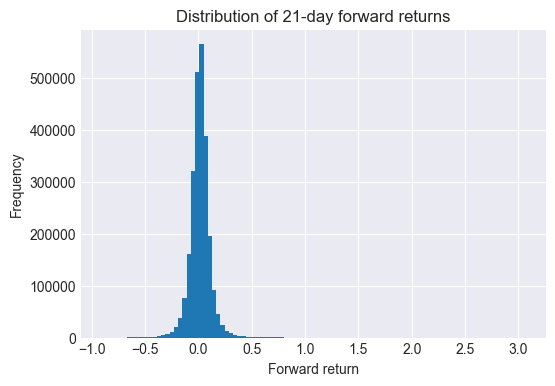

In [4]:
# Load SP500 panel as long as we can reasonably go
# (set force_download=True the first time if needed)
prices = load_sp500_adj_close(start="2000-01-01")

prices.info()
print("Price panel shape:", prices.shape)
print("Date range:", prices.index.min(), "->", prices.index.max())
print("Number of tickers:", len(prices.columns))

lookahead = 21  # ~1 month forward return

signals_df = make_cross_sectional_signals(prices, lookahead=lookahead)

print("Signals shape:", signals_df.shape)
print("Columns:", signals_df.columns.tolist())

dates_all = signals_df.index.get_level_values("date")
tickers_all = signals_df.index.get_level_values("ticker")

print("Signals date range:", dates_all.min(), "->", dates_all.max())
print("Unique tickers in signals:", len(np.unique(tickers_all)))

# Build big (X, y, dates, tickers) matrix
X, y, dates, tickers = build_cross_sectional_matrix(signals_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", CROSS_FEATURES)
print("Min/max date:", dates.min(), "->", dates.max())
print("Num unique tickers:", np.unique(tickers).size)

# Quick sanity check on forward-return distribution
plt.figure(figsize=(6, 4))
plt.hist(y, bins=100)
plt.title(f"Distribution of {lookahead}-day forward returns")
plt.xlabel("Forward return")
plt.ylabel("Frequency")
plt.show()


In [5]:

symbols_path = Path(PROJECT_ROOT) / "data" / "sp500_symbols.csv"
symbols_df = pd.read_csv(symbols_path)

if "sector" in symbols_df.columns:
    sector_map = symbols_df.set_index("symbol")["sector"].to_dict()

    # signals_df has MultiIndex (date, ticker)
    signals_df["sector"] = (
        signals_df.index.get_level_values("ticker")
        .map(sector_map)
        .fillna("ALL")
    )
    print("Added sector column to signals_df.")
else:
    sector_map = None
    print(
        "Warning: sp500_symbols.csv has no 'sector' column – "
        "sector-neutral experiments will be skipped."
    )


In [6]:
def daily_momentum_cs(
    group: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
) -> pd.Series:
    """
    Cross-sectional momentum for a single date.

    group: rows for one date, many tickers.
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon used for the target (e.g. 21 days).
    cost_bps: round-trip cost per 21-day position.
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    # equal-weight all stocks -> "index" (21-day return, frictionless)
    eqw_ret_21 = group["target_fwd_21"].mean()

    # sort by past 21d return (classical cross-sectional momentum)
    g_sorted = group.sort_values("ret_21")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]
    top    = g_sorted.iloc[-k:]

    long_ret_21  = top["target_fwd_21"].mean()
    short_ret_21 = bottom["target_fwd_21"].mean()
    long_short_21 = long_ret_21 - short_ret_21

    # Apply transaction costs on 21-day horizon
    if cost_bps > 0.0:
        long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
        long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

    # convert to daily
    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_ret_daily    = to_daily(eqw_ret_21)
    long_ret_daily   = to_daily(long_ret_21)
    long_short_daily = to_daily(long_short_21)

    return pd.Series(
        {
            "eqw": eqw_ret_daily,
            "long": long_ret_daily,
            "long_short": long_short_daily,
        }
    )


def compute_cs_daily_returns(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    df: index (date, symbol), columns: y_true, y_pred (21d fwd returns + predictions)
    Returns three Series of *daily-equivalent* returns:
        eqw, long-only (top q), long-short (top q minus bottom q)

    cost_bps:
        round-trip transaction cost per 21-day holding period as fraction
        e.g. 0.0005 = 5 bps, 0.001 = 10 bps.
        Applied once for a long-only position and twice for a long-short position.
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Equal-weight all stocks -> benchmark (frictionless)
        eqw_ret_21 = group["y_true"].mean()

        # Sort by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]     # worst predicted
        top    = g_sorted.iloc[-k:]    # best predicted

        long_ret_21  = top["y_true"].mean()
        short_ret_21 = bottom["y_true"].mean()

        long_short_21 = long_ret_21 - short_ret_21

        # apply transaction costs
        if cost_bps > 0.0:
            long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
            long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily        = to_daily(eqw_ret_21)
        long_daily       = to_daily(long_ret_21)
        long_short_daily = to_daily(long_short_21)

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [7]:
def compute_cs_daily_returns_gated(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    Like compute_cs_daily_returns, but:
    - uses model predictions to decide whether to trade at all,
    - only applies costs on days where we actually trade.

    df: index (date, symbol), columns: y_true, y_pred
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Benchmark: equal-weight all stocks (no costs)
        eqw_ret_21 = group["y_true"].mean()

        # Rank by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]
        top    = g_sorted.iloc[-k:]

        # --- True 21d returns (what actually happens) ---
        long_true_21  = top["y_true"].mean()
        short_true_21 = bottom["y_true"].mean()
        long_short_true_21 = long_true_21 - short_true_21

        # --- Predicted 21d returns (model view) ---
        long_pred_21  = top["y_pred"].mean()
        short_pred_21 = bottom["y_pred"].mean()
        long_short_pred_21 = long_pred_21 - short_pred_21

        # ---- Decision: do we trade? ----
        # Long-only: require predicted edge > cost
        trade_long = long_pred_21 > cost_bps

        # Long-short: require predicted spread > 2 * cost
        trade_ls   = long_short_pred_21 > 2.0 * cost_bps

        # Start from "no trade"
        long_ret_21      = 0.0
        long_short_21    = 0.0

        if trade_long:
            long_ret_21 = long_true_21

        if trade_ls:
            long_short_21 = long_short_true_21

        # ---- Apply costs only if we actually trade ----
        if cost_bps > 0.0 and trade_long:
            long_ret_21 = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0

        if cost_bps > 0.0 and trade_ls:
            long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        # Convert 21-day returns to daily-equivalent
        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily        = to_daily(eqw_ret_21)
        long_daily       = to_daily(long_ret_21)
        long_short_daily = to_daily(long_short_21)

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [8]:
def daily_momentum_cs_sector_neutral(
    group: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
) -> pd.Series:
    """
    Sector-neutral cross-sectional momentum for a single date.

    group: rows for one date, many tickers, with columns:
        target_fwd_21, ret_21, sector
    """

    n = len(group)
    if n < 10 or "sector" not in group.columns:
        # Fall back to non-sector version
        return daily_momentum_cs(group, q=q, horizon=horizon, cost_bps=cost_bps)

    # Benchmark (frictionless)
    eqw_ret_21 = group["target_fwd_21"].mean()

    sector_long = []
    sector_short = []

    for sec, g_sec in group.groupby("sector"):
        m = len(g_sec)
        if m < 5:
            continue

        g_sorted = g_sec.sort_values("ret_21")
        k = max(1, int(m * q))

        bottom = g_sorted.iloc[:k]
        top    = g_sorted.iloc[-k:]

        sector_long.append(top["target_fwd_21"].mean())
        sector_short.append(bottom["target_fwd_21"].mean())

    if not sector_long:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    long_ret_21  = float(np.mean(sector_long))
    short_ret_21 = float(np.mean(sector_short))
    long_short_21 = long_ret_21 - short_ret_21

    if cost_bps > 0.0:
        long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
        long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_daily    = to_daily(eqw_ret_21)
    long_daily   = to_daily(long_ret_21)
    ls_daily     = to_daily(long_short_21)

    return pd.Series({"eqw": eqw_daily, "long": long_daily, "long_short": ls_daily})


def compute_cs_daily_returns_sector_neutral(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    Sector-neutral version of compute_cs_daily_returns.
    df: index (date, symbol), columns: y_true, y_pred, sector.
    """

    if "sector" not in df.columns:
        # Graceful fallback
        return compute_cs_daily_returns(df, q=q, horizon=horizon, cost_bps=cost_bps)

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        eqw_ret_21 = group["y_true"].mean()

        sector_long = []
        sector_short = []

        for sec, g_sec in group.groupby("sector"):
            m = len(g_sec)
            if m < 5:
                continue

            g_sorted = g_sec.sort_values("y_pred")
            k = max(1, int(m * q))

            bottom = g_sorted.iloc[:k]
            top    = g_sorted.iloc[-k:]

            sector_long.append(top["y_true"].mean())
            sector_short.append(bottom["y_true"].mean())

        if not sector_long:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        long_ret_21  = float(np.mean(sector_long))
        short_ret_21 = float(np.mean(sector_short))
        long_short_21 = long_ret_21 - short_ret_21

        if cost_bps > 0.0:
            long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
            long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily    = to_daily(eqw_ret_21)
        long_daily   = to_daily(long_ret_21)
        ls_daily     = to_daily(long_short_21)

        return pd.Series({"eqw": eqw_daily, "long": long_daily, "long_short": ls_daily})

    daily = df.groupby("date").apply(_per_date)
    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)
    return eqw, long, long_short


In [9]:
def run_cs_window(
    test_start: str,
    test_end: str,
    X: np.ndarray,
    y: np.ndarray,
    dates: pd.Series,
    tickers: np.ndarray,
    signals_df: pd.DataFrame,
    n_trials: int = 10,
    q_mom: float = 0.1,
    cost_bps: float = COST_BPS,
    random_state: int = 42,
):
    """
    Run the full pipeline for a single test window:
    - Train/val on data *before* test_start
    - Tune tree + XGB + q on validation long-short Sharpe (net of costs)
    - Evaluate momentum, tree, and XGB on [test_start, test_end]
    """
    test_start = pd.Timestamp(test_start)
    test_end   = pd.Timestamp(test_end)

    # Masks for this window
    test_mask = (dates >= test_start) & (dates <= test_end)
    hist_mask = dates < test_start

    if test_mask.sum() == 0 or hist_mask.sum() < 1000:
        print(f"Skipping window {test_start.date()}–{test_end.date()} (not enough data).")
        return None

    # 70/30 split of *history* into train/val
    hist_dates = np.array(sorted(dates[hist_mask].unique()))
    train_end_local = hist_dates[int(len(hist_dates) * 0.7)]

    train_mask = (dates <= train_end_local)
    val_mask   = (dates > train_end_local) & (dates < test_start)

    X_train, y_train = X[train_mask], y[train_mask]
    X_val,   y_val   = X[val_mask],   y[val_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]

    dates_val_local    = dates[val_mask]
    dates_test_local   = dates[test_mask]
    tickers_val_local  = tickers[val_mask]
    tickers_test_local = tickers[test_mask]

    print(
        f"Window {test_start.date()}–{test_end.date()} | "
        f"train={len(y_train)}, val={len(y_val)}, test={len(y_test)}"
    )

    # -------------------------
    # Optuna objectives
    # -------------------------
    def objective_tree_cs(trial):
        max_depth        = trial.suggest_int("max_depth", 2, 8)
        learning_rate    = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_iter         = trial.suggest_int("max_iter", 100, 500)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)
        q                = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

        model = HistGradientBoostingRegressor(
            max_depth=max_depth,
            learning_rate=learning_rate,
            max_iter=max_iter,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
        )
        model.fit(X_train, y_train)

        y_pred_val = model.predict(X_val)

        df_val = (
            pd.DataFrame(
                {
                    "date":   dates_val_local,
                    "symbol": tickers_val_local,
                    "y_true": y_val,
                    "y_pred": y_pred_val,
                }
            )
            .set_index(["date", "symbol"])
            .sort_index()
        )

        # long-short (NET of costs)
        _, _, long_short_val = compute_cs_daily_returns(
            df_val,
            q=q,
            horizon=lookahead,
            cost_bps=cost_bps,
        )

        ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()
        if len(ret_series) < 20:
            return 0.0

        return -sharpe_ratio_np(ret_series.values)

    def objective_xgb_cs(trial):
        # Reasonable XGB hyperparameter ranges
        max_depth        = trial.suggest_int("max_depth", 2, 8)
        learning_rate    = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        n_estimators     = trial.suggest_int("n_estimators", 100, 600)
        subsample        = trial.suggest_float("subsample", 0.6, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        min_child_weight = trial.suggest_float("min_child_weight", 1.0, 20.0)
        q                = trial.suggest_float("q", 0.05, 0.3)

        model = XGBRegressor(
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            min_child_weight=min_child_weight,
            objective="reg:squarederror",
            tree_method="hist",
            n_jobs=-1,
            random_state=random_state,
        )
        model.fit(X_train, y_train)

        y_pred_val = model.predict(X_val)
        df_val = (
            pd.DataFrame(
                {
                    "date":   dates_val_local,
                    "symbol": tickers_val_local,
                    "y_true": y_val,
                    "y_pred": y_pred_val,
                }
            )
            .set_index(["date", "symbol"])
            .sort_index()
        )

        _, _, long_short_val = compute_cs_daily_returns(
            df_val,
            q=q,
            horizon=lookahead,
            cost_bps=cost_bps,
        )

        ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()
        if len(ret_series) < 20:
            return 0.0

        return -sharpe_ratio_np(ret_series.values)

    # --- tune tree ---
    study = optuna.create_study(direction="minimize")
    study.optimize(objective_tree_cs, n_trials=n_trials)
    print("  Tree best params:", study.best_params)
    print("  Tree best val -Sharpe:", study.best_value)

    best_params = study.best_params.copy()
    q_best = best_params.pop("q")

    # --- tune XGB ---
    study_xgb = optuna.create_study(direction="minimize")
    study_xgb.optimize(objective_xgb_cs, n_trials=n_trials)
    print("  XGB best params:", study_xgb.best_params)
    print("  XGB best val -Sharpe:", study_xgb.best_value)

    best_params_xgb = study_xgb.best_params.copy()
    q_best_xgb = best_params_xgb.pop("q")

    # Train on all history (train+val) before test_start
    hist_mask_full = dates < test_start
    X_hist, y_hist = X[hist_mask_full], y[hist_mask_full]

    tree_best = HistGradientBoostingRegressor(
        **best_params,
        random_state=random_state,
    )
    tree_best.fit(X_hist, y_hist)

    xgb_best = XGBRegressor(
        **best_params_xgb,
        objective="reg:squarederror",
        tree_method="hist",
        n_jobs=-1,
        random_state=random_state,
    )
    xgb_best.fit(X_hist, y_hist)

    # -------------------------
    # 1) Momentum baseline on this test window (NET)
    # -------------------------
    idx_dates = signals_df.index.get_level_values("date")
    signals_test = signals_df.loc[
        (idx_dates >= test_start) & (idx_dates <= test_end)
    ].copy()

    daily_mom = signals_test.groupby("date").apply(
        daily_momentum_cs,
        q=q_mom,
        horizon=lookahead,
        cost_bps=cost_bps,
    )

    eqw_returns   = daily_mom["eqw"].astype(float)
    momL_returns  = daily_mom["long"].astype(float)
    momLS_returns = daily_mom["long_short"].astype(float)

    # -------------------------
    # 2) Tree strategy on this test window (NET)
    # -------------------------
    y_pred_test = tree_best.predict(X_test)

    df_test = (
        pd.DataFrame(
            {
                "date":   dates_test_local,
                "symbol": tickers_test_local,
                "y_true": y_test,
                "y_pred": y_pred_test,
            }
        )
        .set_index(["date", "symbol"])
        .sort_index()
    )

    _, treeL_returns, treeLS_returns = compute_cs_daily_returns(
        df_test, q=q_best, horizon=lookahead, cost_bps=cost_bps
    )

    # -------------------------
    # 3) XGB strategy on this test window (NET)
    # -------------------------
    y_pred_test_xgb = xgb_best.predict(X_test)
    df_test_xgb = (
        pd.DataFrame(
            {
                "date":   dates_test_local,
                "symbol": tickers_test_local,
                "y_true": y_test,
                "y_pred": y_pred_test_xgb,
            }
        )
        .set_index(["date", "symbol"])
        .sort_index()
    )

    _, xgbL_returns, xgbLS_returns = compute_cs_daily_returns(
        df_test_xgb,
        q=q_best_xgb,
        horizon=lookahead,
        cost_bps=cost_bps,
    )

    # Equity curves
    eqw_eq     = equity_curve_from_returns(eqw_returns)
    momL_eq    = equity_curve_from_returns(momL_returns)
    momLS_eq   = equity_curve_from_returns(momLS_returns)
    treeL_eq   = equity_curve_from_returns(treeL_returns)
    treeLS_eq  = equity_curve_from_returns(treeLS_returns)
    xgbL_eq    = equity_curve_from_returns(xgbL_returns)
    xgbLS_eq   = equity_curve_from_returns(xgbLS_returns)

    # ---------- Sector-neutral versions (if sector_map is available) ----------
    if "sector_map" in globals() and sector_map is not None:
        df_test_tree_sn = df_test.copy()
        df_test_tree_sn["sector"] = (
            df_test_tree_sn.index.get_level_values("symbol")
            .map(sector_map)
            .fillna("ALL")
        )
        _, treeL_sn_returns, treeLS_sn_returns = compute_cs_daily_returns_sector_neutral(
            df_test_tree_sn,
            q=q_best,
            horizon=lookahead,
            cost_bps=cost_bps,
        )

        df_test_xgb_sn = df_test_xgb.copy()
        df_test_xgb_sn["sector"] = (
            df_test_xgb_sn.index.get_level_values("symbol")
            .map(sector_map)
            .fillna("ALL")
        )
        _, xgbL_sn_returns, xgbLS_sn_returns = compute_cs_daily_returns_sector_neutral(
            df_test_xgb_sn,
            q=q_best_xgb,
            horizon=lookahead,
            cost_bps=cost_bps,
        )
    else:
        # fallback: reuse non-sector-neutral returns
        treeL_sn_returns  = treeL_returns
        treeLS_sn_returns = treeLS_returns
        xgbL_sn_returns   = xgbL_returns
        xgbLS_sn_returns  = xgbLS_returns

    # -------------------------
    # Metrics dict for this window
    # -------------------------
    metrics = {
        "test_start": test_start.date(),
        "test_end":   test_end.date(),

        "momL_cagr":    cagr(momL_eq),
        "momL_sharpe":  sharpe_ratio(momL_returns),
        "momL_max_dd":  max_drawdown(momL_eq),

        "treeL_cagr":   cagr(treeL_eq),
        "treeL_sharpe": sharpe_ratio(treeL_returns),
        "treeL_max_dd": max_drawdown(treeL_eq),

        "momLS_cagr":   cagr(momLS_eq),
        "momLS_sharpe": sharpe_ratio(momLS_returns),
        "momLS_max_dd": max_drawdown(momLS_eq),

        "treeLS_cagr":   cagr(treeLS_eq),
        "treeLS_sharpe": sharpe_ratio(treeLS_returns),
        "treeLS_max_dd": max_drawdown(treeLS_eq),

        "xgbL_cagr":    cagr(xgbL_eq),
        "xgbL_sharpe":  sharpe_ratio(xgbL_returns),
        "xgbLS_cagr":   cagr(xgbLS_eq),
        "xgbLS_sharpe": sharpe_ratio(xgbLS_returns),

        "treeL_sn_sharpe":  sharpe_ratio(treeL_sn_returns),
        "treeLS_sn_sharpe": sharpe_ratio(treeLS_sn_returns),
        "xgbL_sn_sharpe":   sharpe_ratio(xgbL_sn_returns),
        "xgbLS_sn_sharpe":  sharpe_ratio(xgbLS_sn_returns),
    }

    # quick plot for this window
    plt.figure(figsize=(9, 4))
    momL_eq.plot(label="Momentum long-only (net)")
    treeL_eq.plot(label="Tree long-only (net)")
    xgbL_eq.plot(label="XGB long-only (net)", linestyle=":")
    plt.legend()
    plt.title(f"Long-only (net of costs): {test_start.date()}–{test_end.date()}")
    plt.show()

    plt.figure(figsize=(9, 4))
    momLS_eq.plot(label="Momentum long-short (net)")
    treeLS_eq.plot(label="Tree long-short (net)")
    xgbLS_eq.plot(label="XGB long-short (net)", linestyle=":")
    plt.legend()
    plt.title(f"Long-short (net of costs): {test_start.date()}–{test_end.date()}")
    plt.show()

    return metrics


[I 2025-12-25 07:12:07,351] A new study created in memory with name: no-name-c0385b3c-4a90-444b-8493-5d53ae4800c7


Window 2005-01-01–2009-12-31 | train=242459, val=107861, test=459337


[I 2025-12-25 07:12:32,372] Trial 0 finished with value: -1.7461354199618844 and parameters: {'max_depth': 8, 'learning_rate': 0.12962081741071207, 'max_iter': 113, 'min_samples_leaf': 39, 'q': 0.050680155328727036}. Best is trial 0 with value: -1.7461354199618844.
[I 2025-12-25 07:12:38,573] Trial 1 finished with value: -1.3727969796544506 and parameters: {'max_depth': 6, 'learning_rate': 0.15994952940524385, 'max_iter': 132, 'min_samples_leaf': 106, 'q': 0.19127769931533212}. Best is trial 0 with value: -1.7461354199618844.
[I 2025-12-25 07:12:49,142] Trial 2 finished with value: -0.3317934539188502 and parameters: {'max_depth': 4, 'learning_rate': 0.09339627632546059, 'max_iter': 308, 'min_samples_leaf': 150, 'q': 0.22891584552309452}. Best is trial 0 with value: -1.7461354199618844.
[I 2025-12-25 07:12:55,307] Trial 3 finished with value: -0.5474741858407921 and parameters: {'max_depth': 5, 'learning_rate': 0.1752670616988733, 'max_iter': 193, 'min_samples_leaf': 164, 'q': 0.234286

  Tree best params: {'max_depth': 6, 'learning_rate': 0.14481961195761595, 'max_iter': 133, 'min_samples_leaf': 92, 'q': 0.05684351049361937}
  Tree best val -Sharpe: -4.033592204534214


[I 2025-12-25 07:13:47,428] Trial 0 finished with value: 1.1916437357646932 and parameters: {'max_depth': 6, 'learning_rate': 0.08857921276567506, 'n_estimators': 528, 'subsample': 0.9531107175250821, 'colsample_bytree': 0.7379108968105458, 'min_child_weight': 5.847715901685418, 'q': 0.2974176538344772}. Best is trial 0 with value: 1.1916437357646932.
[I 2025-12-25 07:13:54,409] Trial 1 finished with value: 1.5116465148209615 and parameters: {'max_depth': 3, 'learning_rate': 0.0400465706332332, 'n_estimators': 464, 'subsample': 0.9575015984681374, 'colsample_bytree': 0.8086544612072004, 'min_child_weight': 17.169790230350635, 'q': 0.2978800570063656}. Best is trial 0 with value: 1.1916437357646932.
[I 2025-12-25 07:14:03,635] Trial 2 finished with value: -1.8476620116972413 and parameters: {'max_depth': 6, 'learning_rate': 0.17937712960705804, 'n_estimators': 437, 'subsample': 0.8559205397759724, 'colsample_bytree': 0.9160426822182361, 'min_child_weight': 13.442633357075902, 'q': 0.200

  XGB best params: {'max_depth': 7, 'learning_rate': 0.10984494953638677, 'n_estimators': 178, 'subsample': 0.8529535474945296, 'colsample_bytree': 0.8245489528941473, 'min_child_weight': 12.132211209830173, 'q': 0.12154303965043421}
  XGB best val -Sharpe: -2.8483593898976562


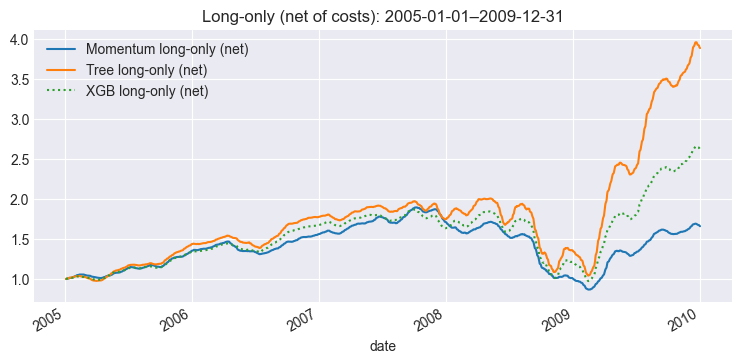

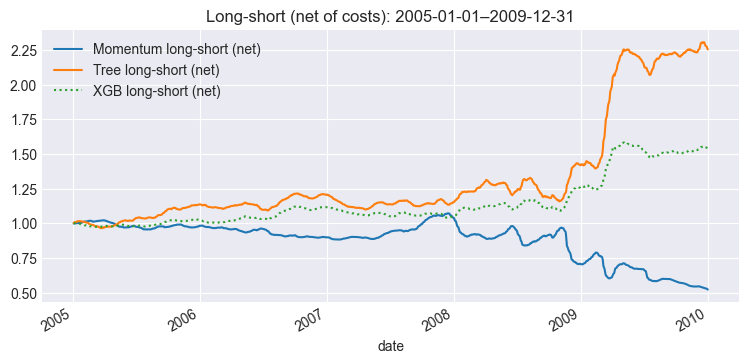

[I 2025-12-25 07:15:17,867] A new study created in memory with name: no-name-f5a58b21-8b2f-4bbb-91aa-d33e25abe6bb


Window 2010-01-01–2014-12-31 | train=549813, val=259844, test=501850


[I 2025-12-25 07:15:42,679] Trial 0 finished with value: -4.241524609776952 and parameters: {'max_depth': 6, 'learning_rate': 0.015647197550168315, 'max_iter': 424, 'min_samples_leaf': 157, 'q': 0.09397609969107985}. Best is trial 0 with value: -4.241524609776952.
[I 2025-12-25 07:16:05,371] Trial 1 finished with value: -4.2276592155487975 and parameters: {'max_depth': 5, 'learning_rate': 0.07669395093144504, 'max_iter': 441, 'min_samples_leaf': 114, 'q': 0.16844359788016366}. Best is trial 0 with value: -4.241524609776952.
[I 2025-12-25 07:16:22,462] Trial 2 finished with value: -3.737628450538801 and parameters: {'max_depth': 6, 'learning_rate': 0.1769890695090686, 'max_iter': 299, 'min_samples_leaf': 147, 'q': 0.22819995360544332}. Best is trial 0 with value: -4.241524609776952.
[I 2025-12-25 07:16:52,441] Trial 3 finished with value: -4.153787831259499 and parameters: {'max_depth': 6, 'learning_rate': 0.018341304097263218, 'max_iter': 485, 'min_samples_leaf': 188, 'q': 0.1309348968

  Tree best params: {'max_depth': 4, 'learning_rate': 0.059055161594254536, 'max_iter': 372, 'min_samples_leaf': 182, 'q': 0.0911344907110815}
  Tree best val -Sharpe: -4.302209959972831


[I 2025-12-25 07:18:26,494] Trial 0 finished with value: -3.6885127812337486 and parameters: {'max_depth': 3, 'learning_rate': 0.1299002522325039, 'n_estimators': 309, 'subsample': 0.8346977916450813, 'colsample_bytree': 0.8147217223222246, 'min_child_weight': 12.606542848845685, 'q': 0.20795961673981656}. Best is trial 0 with value: -3.6885127812337486.
[I 2025-12-25 07:18:52,630] Trial 1 finished with value: -3.175214589983065 and parameters: {'max_depth': 8, 'learning_rate': 0.16512366170459555, 'n_estimators': 439, 'subsample': 0.7002907303093063, 'colsample_bytree': 0.7320028001817448, 'min_child_weight': 18.5775269591005, 'q': 0.28112833445649227}. Best is trial 0 with value: -3.6885127812337486.
[I 2025-12-25 07:19:02,865] Trial 2 finished with value: -3.672381021255033 and parameters: {'max_depth': 5, 'learning_rate': 0.041527817912594564, 'n_estimators': 203, 'subsample': 0.7626310402817652, 'colsample_bytree': 0.9140231007713779, 'min_child_weight': 3.4653603175064704, 'q': 0

  XGB best params: {'max_depth': 3, 'learning_rate': 0.06278567066078128, 'n_estimators': 441, 'subsample': 0.8828805480223144, 'colsample_bytree': 0.909320972269039, 'min_child_weight': 19.163374535542022, 'q': 0.05605610224325154}
  XGB best val -Sharpe: -4.112502090348295


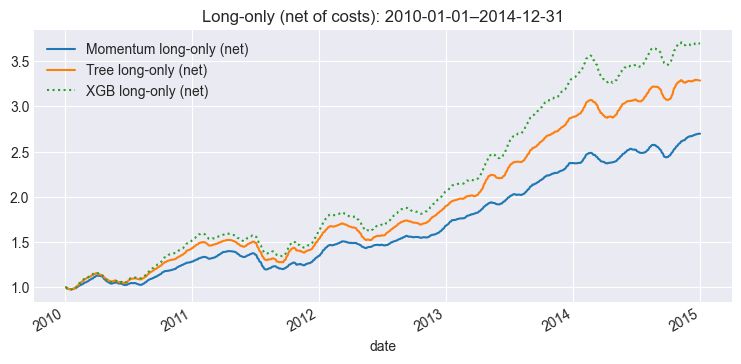

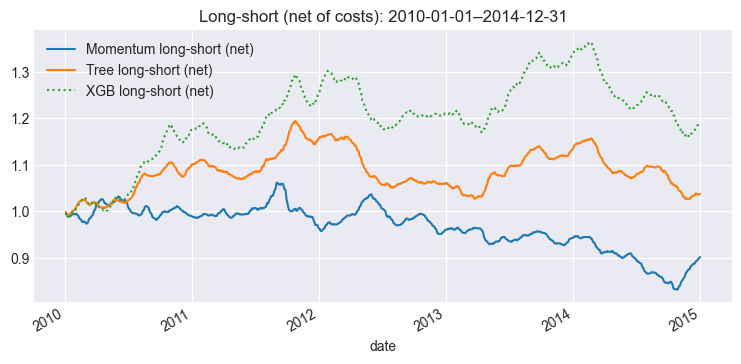

[I 2025-12-25 07:22:29,176] A new study created in memory with name: no-name-f13b1e19-c848-4c4f-91cd-a2837920b078


Window 2015-01-01–2019-12-31 | train=880883, val=430624, test=536253


[I 2025-12-25 07:22:50,869] Trial 0 finished with value: -0.6467535092744785 and parameters: {'max_depth': 8, 'learning_rate': 0.017172312600878103, 'max_iter': 200, 'min_samples_leaf': 125, 'q': 0.18777982720875636}. Best is trial 0 with value: -0.6467535092744785.
[I 2025-12-25 07:23:31,189] Trial 1 finished with value: 0.25827369547898305 and parameters: {'max_depth': 5, 'learning_rate': 0.014882651914523662, 'max_iter': 379, 'min_samples_leaf': 199, 'q': 0.24972070320149325}. Best is trial 0 with value: -0.6467535092744785.
[I 2025-12-25 07:23:47,542] Trial 2 finished with value: -1.1719139742737048 and parameters: {'max_depth': 3, 'learning_rate': 0.05883591159343195, 'max_iter': 171, 'min_samples_leaf': 110, 'q': 0.05139314488388365}. Best is trial 2 with value: -1.1719139742737048.
[I 2025-12-25 07:24:03,077] Trial 3 finished with value: -1.4253606891010915 and parameters: {'max_depth': 5, 'learning_rate': 0.018307935314193752, 'max_iter': 123, 'min_samples_leaf': 44, 'q': 0.061

  Tree best params: {'max_depth': 5, 'learning_rate': 0.018307935314193752, 'max_iter': 123, 'min_samples_leaf': 44, 'q': 0.06181780860673568}
  Tree best val -Sharpe: -1.4253606891010915


[I 2025-12-25 07:27:28,853] Trial 0 finished with value: 0.526202408235213 and parameters: {'max_depth': 7, 'learning_rate': 0.042144780384264766, 'n_estimators': 276, 'subsample': 0.6844675844043699, 'colsample_bytree': 0.8659947817368174, 'min_child_weight': 10.176969291513693, 'q': 0.11945245347057341}. Best is trial 0 with value: 0.526202408235213.
[I 2025-12-25 07:27:41,358] Trial 1 finished with value: -0.9486733532470834 and parameters: {'max_depth': 5, 'learning_rate': 0.012153946488698416, 'n_estimators': 122, 'subsample': 0.6328848365170743, 'colsample_bytree': 0.9053374308251805, 'min_child_weight': 8.171002009994416, 'q': 0.10630648527678264}. Best is trial 1 with value: -0.9486733532470834.
[I 2025-12-25 07:27:57,727] Trial 2 finished with value: -0.8847546222898163 and parameters: {'max_depth': 2, 'learning_rate': 0.041309130581514836, 'n_estimators': 237, 'subsample': 0.7300514647051805, 'colsample_bytree': 0.9036639421442821, 'min_child_weight': 4.7254548233392875, 'q':

  XGB best params: {'max_depth': 5, 'learning_rate': 0.012153946488698416, 'n_estimators': 122, 'subsample': 0.6328848365170743, 'colsample_bytree': 0.9053374308251805, 'min_child_weight': 8.171002009994416, 'q': 0.10630648527678264}
  XGB best val -Sharpe: -0.9486733532470834


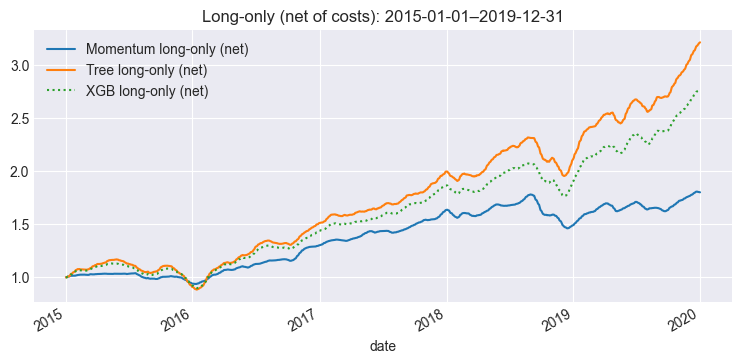

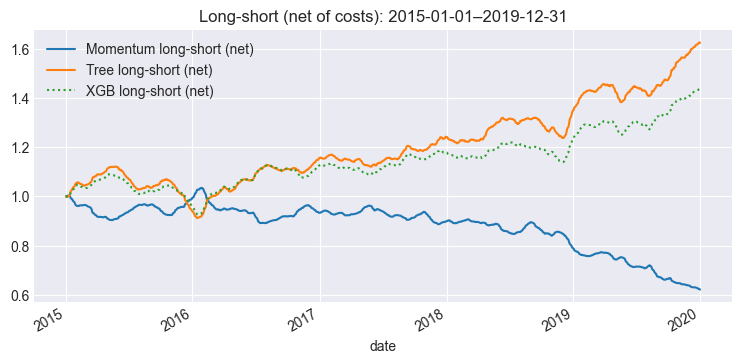

[I 2025-12-25 07:32:58,286] A new study created in memory with name: no-name-4c5ffad2-0f91-44ff-8ca6-2139d989b4e5


Window 2020-01-01–2024-12-31 | train=1232188, val=615572, test=558111


[I 2025-12-25 07:33:32,347] Trial 0 finished with value: -3.243141751274582 and parameters: {'max_depth': 2, 'learning_rate': 0.027899507242689005, 'max_iter': 451, 'min_samples_leaf': 22, 'q': 0.08165770424745462}. Best is trial 0 with value: -3.243141751274582.
[I 2025-12-25 07:34:02,255] Trial 1 finished with value: -1.2762900461086466 and parameters: {'max_depth': 8, 'learning_rate': 0.11999997918933929, 'max_iter': 278, 'min_samples_leaf': 183, 'q': 0.21010662167584931}. Best is trial 0 with value: -3.243141751274582.
[I 2025-12-25 07:34:20,650] Trial 2 finished with value: -2.669807590379915 and parameters: {'max_depth': 4, 'learning_rate': 0.060603429902688945, 'max_iter': 164, 'min_samples_leaf': 53, 'q': 0.08972216582324348}. Best is trial 0 with value: -3.243141751274582.
[I 2025-12-25 07:35:01,651] Trial 3 finished with value: -1.1375336943690584 and parameters: {'max_depth': 7, 'learning_rate': 0.13248314840690203, 'max_iter': 331, 'min_samples_leaf': 138, 'q': 0.2486058728

  Tree best params: {'max_depth': 2, 'learning_rate': 0.027899507242689005, 'max_iter': 451, 'min_samples_leaf': 22, 'q': 0.08165770424745462}
  Tree best val -Sharpe: -3.243141751274582


[I 2025-12-25 07:39:01,712] Trial 0 finished with value: -2.548232311012094 and parameters: {'max_depth': 4, 'learning_rate': 0.011950033205753373, 'n_estimators': 307, 'subsample': 0.6655376922237737, 'colsample_bytree': 0.7164467298750324, 'min_child_weight': 15.906218988638017, 'q': 0.1958178170714684}. Best is trial 0 with value: -2.548232311012094.
[I 2025-12-25 07:39:36,427] Trial 1 finished with value: -2.382377378948933 and parameters: {'max_depth': 4, 'learning_rate': 0.035558922014342416, 'n_estimators': 415, 'subsample': 0.6692617529048155, 'colsample_bytree': 0.6044187298402083, 'min_child_weight': 5.5550378110618075, 'q': 0.28879955514136896}. Best is trial 0 with value: -2.548232311012094.
[I 2025-12-25 07:39:48,023] Trial 2 finished with value: -2.315443332838763 and parameters: {'max_depth': 3, 'learning_rate': 0.02562555516827522, 'n_estimators': 121, 'subsample': 0.6184476947570771, 'colsample_bytree': 0.797784411978493, 'min_child_weight': 14.395582887662737, 'q': 0.

  XGB best params: {'max_depth': 8, 'learning_rate': 0.01055990732586593, 'n_estimators': 150, 'subsample': 0.6199518507436662, 'colsample_bytree': 0.770067169606948, 'min_child_weight': 18.126714379368412, 'q': 0.08954678169009693}
  XGB best val -Sharpe: -3.173788234186914


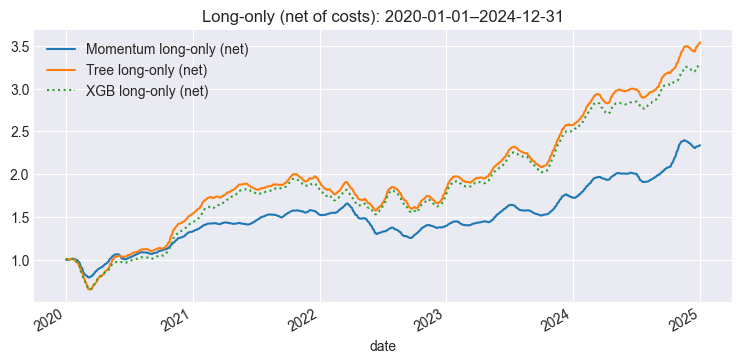

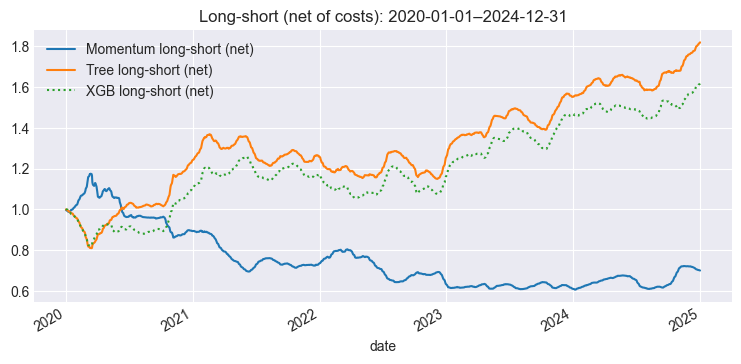

,test_start,test_end,momL_cagr,momL_sharpe,momL_max_dd,treeL_cagr,treeL_sharpe,treeL_max_dd,momLS_cagr,momLS_sharpe,...,treeLS_sharpe,treeLS_max_dd,xgbL_cagr,xgbL_sharpe,xgbLS_cagr,xgbLS_sharpe,treeL_sn_sharpe,treeLS_sn_sharpe,xgbL_sn_sharpe,xgbLS_sn_sharpe
0,2005-01-01,2009-12-31,0.106992,1.861044,-0.541993,0.311922,3.401621,-0.480407,-0.121386,-1.875314,...,3.388954,-0.127620,0.212880,2.872315,0.089249,2.708519,3.401621,3.388954,2.872315,2.708519
1,2010-01-01,2014-12-31,0.220422,6.471051,-0.146564,0.269484,6.532657,-0.163252,-0.020076,-0.933459,...,0.381389,-0.141183,0.299761,6.635555,0.036118,1.432103,6.532657,0.381389,6.635555,1.432103
2,2015-01-01,2019-12-31,0.125113,4.379338,-0.179420,0.263633,6.293493,-0.243533,-0.091091,-3.260790,...,3.252950,-0.186661,0.226776,6.065373,0.075427,2.815604,6.293493,3.252950,6.065373,2.815604
3,2020-01-01,2024-12-31,0.185737,3.690401,-0.243806,0.288018,4.109351,-0.355442,-0.068187,-1.396745,...,2.850978,-0.189948,0.269492,3.957446,0.100461,2.263711,4.109351,2.850978,3.957446,2.263711


In [10]:
test_windows = [
    ("2005-01-01", "2009-12-31"),
    ("2010-01-01", "2014-12-31"),
    ("2015-01-01", "2019-12-31"),
    ("2020-01-01", "2024-12-31"),
]

results = []
for start, end in test_windows:
    print("=" * 80)
    m = run_cs_window(
        start,
        end,
        X=X,
        y=y,
        dates=dates,
        tickers=tickers,
        signals_df=signals_df,
        n_trials=10,
        q_mom=0.1,
    )
    if m is not None:
        results.append(m)

results_df = pd.DataFrame(results)
results_df


In [11]:
summary_cols = [
    "test_start", "test_end",
    "momL_sharpe", "treeL_sharpe", "xgbL_sharpe",
    "momLS_sharpe", "treeLS_sharpe", "xgbLS_sharpe",
]


summary = results_df[summary_cols].copy()
summary


,test_start,test_end,momL_sharpe,treeL_sharpe,xgbL_sharpe,momLS_sharpe,treeLS_sharpe,xgbLS_sharpe
0,2005-01-01,2009-12-31,1.861044,3.401621,2.872315,-1.875314,3.388954,2.708519
1,2010-01-01,2014-12-31,6.471051,6.532657,6.635555,-0.933459,0.381389,1.432103
2,2015-01-01,2019-12-31,4.379338,6.293493,6.065373,-3.260790,3.252950,2.815604
3,2020-01-01,2024-12-31,3.690401,4.109351,3.957446,-1.396745,2.850978,2.263711


In [12]:
summary["treeL_minus_momL"]   = summary["treeL_sharpe"]  - summary["momL_sharpe"]
summary["treeLS_minus_momLS"] = summary["treeLS_sharpe"] - summary["momLS_sharpe"]

summary


,test_start,test_end,momL_sharpe,treeL_sharpe,xgbL_sharpe,momLS_sharpe,treeLS_sharpe,xgbLS_sharpe,treeL_minus_momL,treeLS_minus_momLS
0,2005-01-01,2009-12-31,1.861044,3.401621,2.872315,-1.875314,3.388954,2.708519,1.540577,5.264269
1,2010-01-01,2014-12-31,6.471051,6.532657,6.635555,-0.933459,0.381389,1.432103,0.061606,1.314848
2,2015-01-01,2019-12-31,4.379338,6.293493,6.065373,-3.260790,3.252950,2.815604,1.914155,6.513739
3,2020-01-01,2024-12-31,3.690401,4.109351,3.957446,-1.396745,2.850978,2.263711,0.418950,4.247723


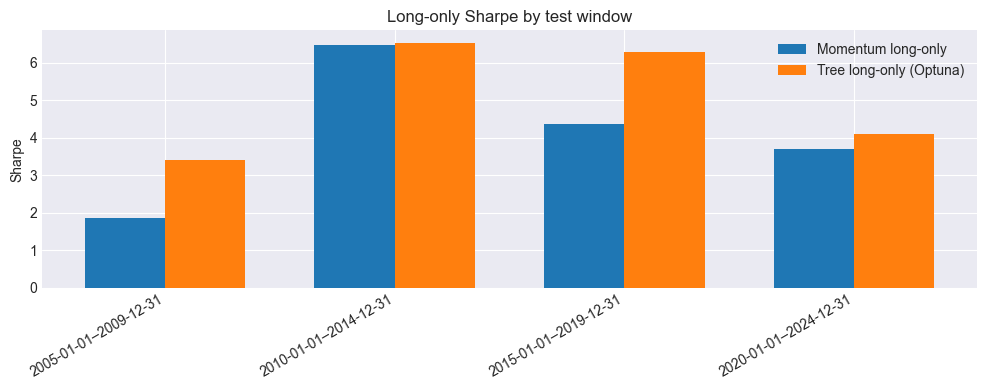

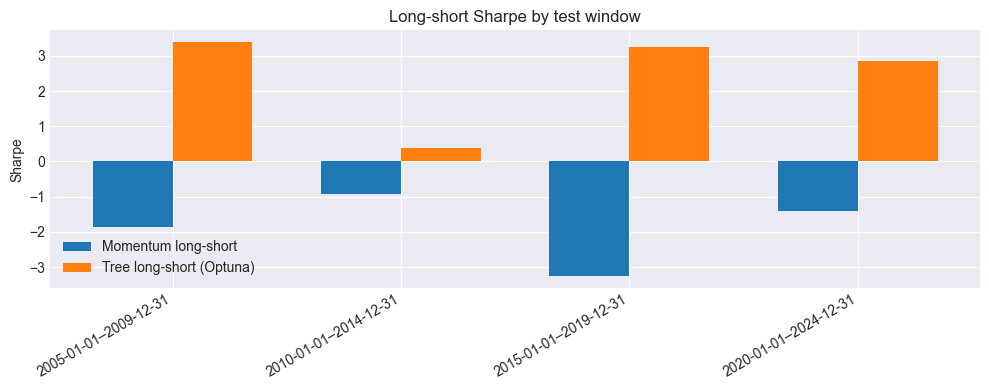

In [13]:
# Nice labels for windows
window_labels = (
    results_df["test_start"].astype(str)
    + "–"
    + results_df["test_end"].astype(str)
)
x = np.arange(len(results_df))
width = 0.35

# --- Long-only Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momL_sharpe"], width, label="Momentum long-only")
plt.bar(x + width/2, results_df["treeL_sharpe"], width, label="Tree long-only (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-only Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()

# --- Long-short Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momLS_sharpe"], width, label="Momentum long-short")
plt.bar(x + width/2, results_df["treeLS_sharpe"], width, label="Tree long-short (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-short Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()


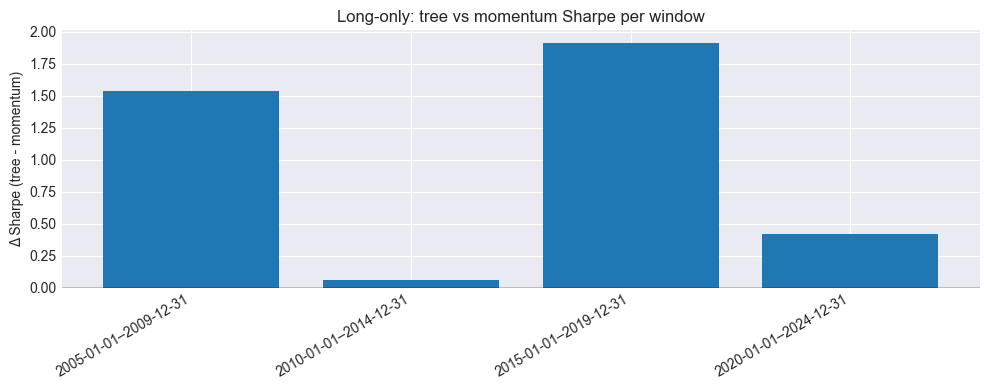

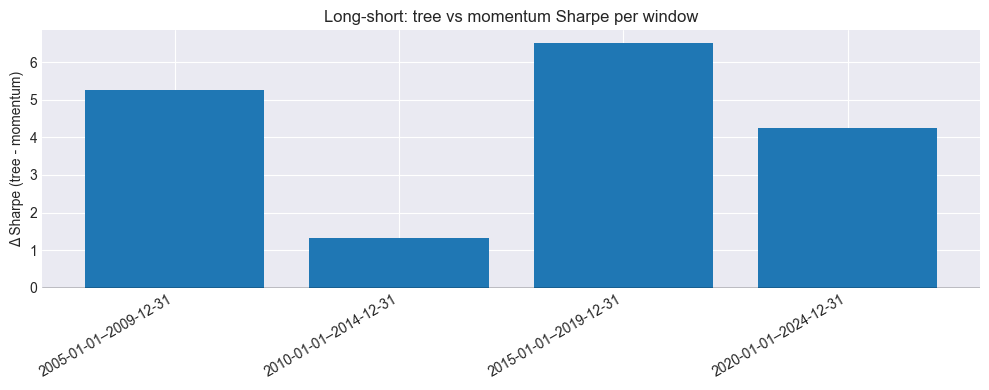

In [14]:
# Add differences if not already there
results_df["treeL_minus_momL"]   = results_df["treeL_sharpe"]  - results_df["momL_sharpe"]
results_df["treeLS_minus_momLS"] = results_df["treeLS_sharpe"] - results_df["momLS_sharpe"]

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeL_minus_momL"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-only: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeLS_minus_momLS"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-short: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()


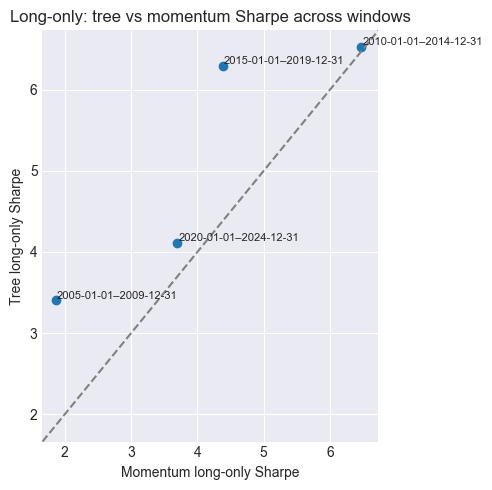

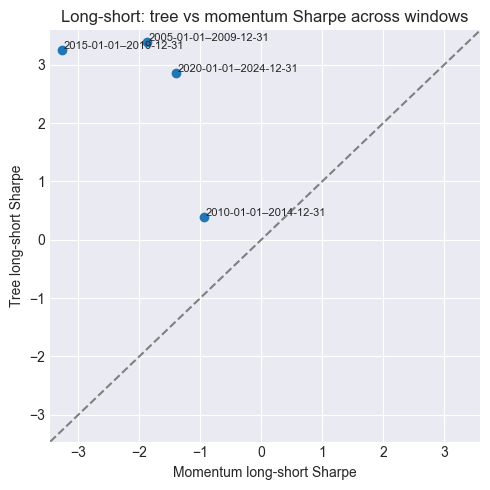

In [15]:
# Long-only scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momL_sharpe"], results_df["treeL_sharpe"])
lims = [
    min(results_df["momL_sharpe"].min(), results_df["treeL_sharpe"].min()) - 0.2,
    max(results_df["momL_sharpe"].max(), results_df["treeL_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")  # y = x line
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momL_sharpe"].iloc[i] + 0.02,
        results_df["treeL_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-only Sharpe")
plt.ylabel("Tree long-only Sharpe")
plt.title("Long-only: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()

# Long-short scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momLS_sharpe"], results_df["treeLS_sharpe"])
lims = [
    min(results_df["momLS_sharpe"].min(), results_df["treeLS_sharpe"].min()) - 0.2,
    max(results_df["momLS_sharpe"].max(), results_df["treeLS_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momLS_sharpe"].iloc[i] + 0.02,
        results_df["treeLS_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-short Sharpe")
plt.ylabel("Tree long-short Sharpe")
plt.title("Long-short: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()


In [16]:
# === PAPER TRADING MODE, FOR RESEARCH PURPOSE ONLY: cross-sectional SP500 picks for "tomorrow" ===

from IPython.display import display

TOP_N_LONG = 20   # how many longs to show
TOP_N_SHORT = 20  # how many shorts to show

# 1) Choose as-of date: last date where we have signals/targets
as_of_date = dates.max()
print(f"As-of date for paper trading: {as_of_date.date()}")

# ----- build train / val sets using only history before as_of_date -----
hist_mask = dates < as_of_date
if hist_mask.sum() < 1000:
    raise ValueError("Not enough history before as_of_date for a meaningful model.")

hist_dates = np.array(sorted(dates[hist_mask].unique()))
train_end_live = hist_dates[int(len(hist_dates) * 0.7)]

train_mask_live = (dates <= train_end_live)
val_mask_live   = (dates > train_end_live) & (dates < as_of_date)

X_train_live, y_train_live = X[train_mask_live], y[train_mask_live]
X_val_live,   y_val_live   = X[val_mask_live],   y[val_mask_live]

dates_val_live   = dates[val_mask_live]
tickers_val_live = tickers[val_mask_live]

print(
    f"Live setup | train={len(y_train_live)} samples "
    f"val={len(y_val_live)} samples (all < {as_of_date.date()})"
)

# 2) Optuna objective: tune tree hyperparams + q on long-short Sharpe (net of cost)
def objective_tree_live(trial):
    max_depth       = trial.suggest_int("max_depth", 2, 8)
    learning_rate   = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    max_iter        = trial.suggest_int("max_iter", 100, 500)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)
    q               = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

    model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        max_iter=max_iter,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    model.fit(X_train_live, y_train_live)

    y_pred_val = model.predict(X_val_live)

    df_val_live = (
        pd.DataFrame(
            {
                "date":   dates_val_live,
                "symbol": tickers_val_live,
                "y_true": y_val_live,
                "y_pred": y_pred_val,
            }
        )
        .set_index(["date", "symbol"])
        .sort_index()
    )

    # build long/short portfolios on validation (net of transaction costs)
    _, long_val, long_short_val = compute_cs_daily_returns(
        df_val_live,
        q=q,
        horizon=lookahead,
        cost_bps=COST_BPS,
    )

    ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()
    if len(ret_series) < 20:
        return 0.0  # treat as bad if too little data

    return -sharpe_ratio_np(ret_series.values)  # Optuna MINIMIZES

study_live = optuna.create_study(direction="minimize")
study_live.optimize(objective_tree_live, n_trials=20)

print("Best live params:", study_live.best_params)
print("Best live val -Sharpe:", study_live.best_value)

best_live = study_live.best_params.copy()
q_live = best_live.pop("q")

# 3) Train final tree on ALL history before as_of_date
tree_live = HistGradientBoostingRegressor(
    **best_live,
    random_state=42,
)

X_hist_live = X[hist_mask]
y_hist_live = y[hist_mask]
tree_live.fit(X_hist_live, y_hist_live)

# 4) Predictions for the as-of date (our "today")
live_mask = dates == as_of_date
X_live = X[live_mask]
tickers_live = tickers[live_mask]

y_pred_live = tree_live.predict(X_live)

panel_live = pd.DataFrame(
    {
        "ticker": tickers_live,
        "pred_fwd_21": y_pred_live,   # model prediction: 21d total return (gross)
    }
).set_index("ticker")

# approximate net-of-fee 21d return for a long position
panel_live["pred_fwd_21_net_long"] = (1.0 + panel_live["pred_fwd_21"]) * (1.0 - COST_BPS) - 1.0
panel_live["pred_daily_net_long"] = (1.0 + panel_live["pred_fwd_21_net_long"]) ** (1.0 / lookahead) - 1.0

# cross-sectional average daily net return (like EW benchmark)
mean_daily_net = panel_live["pred_daily_net_long"].mean()
panel_live["edge_vs_eqw_daily"] = panel_live["pred_daily_net_long"] - mean_daily_net

# 5) Sort and show top/bottom N
panel_sorted = panel_live.sort_values("pred_fwd_21_net_long", ascending=False)

top_long  = panel_sorted.head(TOP_N_LONG).copy()
bottom_short = panel_sorted.tail(TOP_N_SHORT).copy()

print("\n=== Paper-trade recommendation ===")
print(f"As-of date: {as_of_date.date()}  |  lookahead: {lookahead} days")
print(
    f"Tuned q_live = {q_live:.3f}  "
    f"(strategy would typically long/short ~{int(q_live * len(panel_sorted))} names per side)"
)
print(f"Assumed round-trip cost: {COST_BPS * 1e4:.1f} bps per 21d holding period")

print("\nTop tickers to LONG (preview, net of costs):")
display(
    top_long[
        ["pred_fwd_21", "pred_fwd_21_net_long", "pred_daily_net_long", "edge_vs_eqw_daily"]
    ].sort_values("pred_fwd_21_net_long", ascending=False)
)

print("\nBottom tickers to SHORT (preview, net of costs):")
# for shorts, a strongly negative predicted return is good
display(
    bottom_short[
        ["pred_fwd_21", "pred_fwd_21_net_long", "pred_daily_net_long", "edge_vs_eqw_daily"]
    ].sort_values("pred_fwd_21_net_long")  # most negative first
)


As-of date for paper trading: 2025-11-17


[I 2025-12-25 07:45:16,516] A new study created in memory with name: no-name-e3dc8294-373f-435e-b7d3-38643fb2b310


Live setup | train=1668712 samples val=835884 samples (all < 2025-11-17)


[I 2025-12-25 07:45:51,351] Trial 0 finished with value: -2.42962008213047 and parameters: {'max_depth': 4, 'learning_rate': 0.01181444666507441, 'max_iter': 207, 'min_samples_leaf': 117, 'q': 0.11401910678083411}. Best is trial 0 with value: -2.42962008213047.
[I 2025-12-25 07:46:31,222] Trial 1 finished with value: -3.0720530288695675 and parameters: {'max_depth': 2, 'learning_rate': 0.019804409581200673, 'max_iter': 234, 'min_samples_leaf': 134, 'q': 0.06654118968583984}. Best is trial 1 with value: -3.0720530288695675.
[I 2025-12-25 07:47:27,878] Trial 2 finished with value: -1.5814758431044038 and parameters: {'max_depth': 2, 'learning_rate': 0.11709360907008537, 'max_iter': 478, 'min_samples_leaf': 176, 'q': 0.20484513387502645}. Best is trial 1 with value: -3.0720530288695675.
[I 2025-12-25 07:48:25,426] Trial 3 finished with value: -2.4477761360527532 and parameters: {'max_depth': 2, 'learning_rate': 0.020420080990124132, 'max_iter': 459, 'min_samples_leaf': 63, 'q': 0.17420352

Best live params: {'max_depth': 2, 'learning_rate': 0.019804409581200673, 'max_iter': 234, 'min_samples_leaf': 134, 'q': 0.06654118968583984}
Best live val -Sharpe: -3.0720530288695675

=== Paper-trade recommendation ===
As-of date: 2025-11-17  |  lookahead: 21 days
Tuned q_live = 0.067  (strategy would typically long/short ~29 names per side)
Assumed round-trip cost: 10.0 bps per 21d holding period

Top tickers to LONG (preview, net of costs):


,pred_fwd_21,pred_fwd_21_net_long,pred_daily_net_long,edge_vs_eqw_daily
ticker,,,,
MOH,0.038348,0.037309,0.001746,0.001109
STX,0.035879,0.034843,0.001632,0.000995
HOOD,0.035790,0.034754,0.001628,0.000991
WDC,0.035319,0.034284,0.001606,0.000969
MU,0.035018,0.033983,0.001593,0.000955
TER,0.033252,0.032218,0.001511,0.000874
WBD,0.033237,0.032204,0.001510,0.000873
APP,0.031581,0.030549,0.001434,0.000797
PLTR,0.031504,0.030472,0.001430,0.000793



Bottom tickers to SHORT (preview, net of costs):


,pred_fwd_21,pred_fwd_21_net_long,pred_daily_net_long,edge_vs_eqw_daily
ticker,,,,
VRTX,0.008201,0.007193,0.000341,-0.000296
UPS,0.008207,0.007199,0.000342,-0.000296
WELL,0.008245,0.007237,0.000343,-0.000294
MCK,0.008245,0.007237,0.000343,-0.000294
CBOE,0.008245,0.007237,0.000343,-0.000294
CSCO,0.008245,0.007237,0.000343,-0.000294
HCA,0.008245,0.007237,0.000343,-0.000294
FDX,0.008245,0.007237,0.000343,-0.000294
EW,0.008245,0.007237,0.000343,-0.000294


In [17]:
# =============================================================================
# Final live model: global tuning on full history, then train once & save
# =============================================================================

# 1) Global train/validation split over all dates (for hyperparameter tuning)
all_dates = np.array(sorted(dates.unique()))
split_idx = int(len(all_dates) * 0.7)
train_end_global = all_dates[split_idx]

mask_train_global = dates <= train_end_global
mask_val_global   = dates > train_end_global

X_train_g, y_train_g = X[mask_train_global], y[mask_train_global]
X_val_g,   y_val_g   = X[mask_val_global],   y[mask_val_global]

dates_val_g   = dates[mask_val_global]
tickers_val_g = tickers[mask_val_global]

print("Global tuning:")
print("  Train dates:", dates[mask_train_global].min(), "->", dates[mask_train_global].max())
print("  Val   dates:", dates_val_g.min(), "->", dates_val_g.max())
print("  Train samples:", len(y_train_g), " Val samples:", len(y_val_g))


def objective_tree_global(trial):
    # --- Tree hyperparameters ---
    max_depth = trial.suggest_int("max_depth", 2, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 500)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)
    # long/short bucket size
    q = trial.suggest_float("q", 0.05, 0.3)

    model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        max_iter=max_iter,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    model.fit(X_train_g, y_train_g)

    # Predictions on validation
    y_pred_val = model.predict(X_val_g)

    df_val_g = (
        pd.DataFrame(
            {
                "date":   dates_val_g,
                "symbol": tickers_val_g,
                "y_true": y_val_g,
                "y_pred": y_pred_val,
            }
        )
        .set_index(["date", "symbol"])
        .sort_index()
    )

    # Build long-only & long-short portfolios on validation, NET of costs
    _, long_val_g, long_short_val_g = compute_cs_daily_returns(
        df_val_g,
        q=q,
        horizon=lookahead,
        cost_bps=COST_BPS,
    )

    # We optimize **long-only** net Sharpe (you can switch to long_short_val_g if you want)
    ret_series = long_val_g.replace([np.inf, -np.inf], np.nan).dropna()
    if len(ret_series) < 20:
        return 0.0

    return -sharpe_ratio_np(ret_series.values)


study_global = optuna.create_study(direction="minimize")
study_global.optimize(objective_tree_global, n_trials=20)

print("Global best params:", study_global.best_params)
print("Global best -Sharpe (long-only, net):", study_global.best_value)

best_params_live = study_global.best_params.copy()
q_live = best_params_live.pop("q")


# 2) Train final model on ALL labeled history (X, y)
tree_cs_final = HistGradientBoostingRegressor(
    **best_params_live,
    random_state=42,
)
tree_cs_final.fit(X, y)

print("Final model trained on:", dates.min(), "->", dates.max())
print("Final model train R^2:", tree_cs_final.score(X, y))


# 3) Save bundle to disk for inference
models_dir = Path(PROJECT_ROOT) / "models"
models_dir.mkdir(exist_ok=True)

bundle = {
    "model": tree_cs_final,
    "q_live": q_live,
    "lookahead": lookahead,
    "cost_bps": COST_BPS,
    "features": CROSS_FEATURES,
    "train_start": str(dates.min().date()),
    "train_end":   str(dates.max().date()),
    "optuna_best_params": study_global.best_params,
    "optuna_best_value":  float(study_global.best_value),
}

out_path = models_dir / "sp500_tree_cs_21d_live.pkl"
joblib.dump(bundle, out_path)

print("Saved live model bundle to:", out_path)
print("q_live (fraction of names long/short):", q_live)


[I 2025-12-25 07:59:59,881] A new study created in memory with name: no-name-e74af7a2-bc0c-470b-9480-868837a4816e


Global tuning:
  Train dates: 2000-10-16 00:00:00 -> 2018-05-09 00:00:00
  Val   dates: 2018-05-10 00:00:00 -> 2025-11-17 00:00:00
  Train samples: 1669142  Val samples: 835903


[I 2025-12-25 08:00:40,793] Trial 0 finished with value: -3.6142126899653992 and parameters: {'max_depth': 2, 'learning_rate': 0.036780560003917176, 'max_iter': 396, 'min_samples_leaf': 38, 'q': 0.2828544657014504}. Best is trial 0 with value: -3.6142126899653992.
[I 2025-12-25 08:01:18,547] Trial 1 finished with value: -4.066332283399506 and parameters: {'max_depth': 7, 'learning_rate': 0.03682930146031714, 'max_iter': 219, 'min_samples_leaf': 131, 'q': 0.06554662915308569}. Best is trial 1 with value: -4.066332283399506.
[I 2025-12-25 08:02:17,488] Trial 2 finished with value: -3.5421158097605994 and parameters: {'max_depth': 7, 'learning_rate': 0.02979356394403222, 'max_iter': 378, 'min_samples_leaf': 99, 'q': 0.23348815637565717}. Best is trial 1 with value: -4.066332283399506.
[I 2025-12-25 08:03:10,111] Trial 3 finished with value: -3.7011026177006756 and parameters: {'max_depth': 8, 'learning_rate': 0.011402761642498042, 'max_iter': 280, 'min_samples_leaf': 183, 'q': 0.184334774

Global best params: {'max_depth': 3, 'learning_rate': 0.1933414212267616, 'max_iter': 359, 'min_samples_leaf': 160, 'q': 0.05031110278397034}
Global best -Sharpe (long-only, net): -4.375322194470539
Final model trained on: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Final model train R^2: 0.03688936935550913
Saved live model bundle to: c:\Users\gehra\Documents\GitHub\Quant_coding\models\sp500_tree_cs_21d_live.pkl
q_live (fraction of names long/short): 0.05031110278397034
